# Recommendation Systems Project

### Getting MovieLens data to run the code

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [0]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

import warnings
warnings.filterwarnings('ignore') #ignore warnings

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=6b60d9392a2e977c14e50aa1675f9545b82717452da6ef77f158a11218150432
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [0]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [0]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Data Preprocessing and Baseline algorithms

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """

    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp, *args) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating 
        
    return matrix

In [0]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### Baseline Models- Popularity and User Average

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))

        for (user,item), rating in np.ndenumerate(train_matrix):
          userVector = train_matrix[user, :]
          ratedItems = userVector[userVector.nonzero()]
            
          # If not empty, calculate average and set as rating for the current item
          if ratedItems.size == 0:
              itemAvg = 0
          else:
              itemAvg = ratedItems.mean()
          predictionMatrix[user, item] = itemAvg
            
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))

        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        # Initialize the predicted rating matrix with zeros

        predictionMatrix = np.zeros((num_users, num_items))
    
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            predictionMatrix[user, item] = itemPopularity[item]
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
                   
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()

In [0]:
np.all(x<=1)

True

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:27, 1137.04it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [0]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:27, 1139.48it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Similarity metrics in Collaborative Filtering

- cosine similarity
- eucledian similarity
- jaccard similarity

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """

        similarity_matrix = 1/ (1+pairwise_distances(matrix, metric='euclidean')) 
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
    
        similarity_matrix = 1 - pairwise_distances(matrix, metric='jaccard') 

        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':

            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity= self.method(train_matrix)

            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            
        elif self.base == 'item':

            train_matrix= train_matrix.T
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity= self.method(train_matrix)

            # UxI: UxU mul UxI
            normalizer = np.matmul(ii_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.T          

        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [0]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [0]:
SimBasedRecSys.somethingelse(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

Cosine distance is the better similarity metric since it does not take magnitude of vectors into account like the Euclidean distance. 

Jaccard was used since it has been used extensively in research papers for recommender systems. It also gave a pretty competetive RMSE value when compared to cosine similarity.

Jaccard gives a measure of similarity between two sets by counting the number of items they have in common and dividing by the total number of unique items between them. Essentially, it's the ratio of the number of items they both share compared to the number of items they could potentially share.

## Collaborative Filtering- User User and Item Item

This is done for all the three similarity metrics

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:41, 984.03it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [0]:
user_euclidean_recsys= SimBasedRecSys('user','euclidean')

In [0]:
user_euclidean_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_euclidean_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:28, 1124.25it/s]


,userID,itemID,rating,timestamp,user-euclidean
0,196,242,3,881250949,3.769730
1,186,302,3,891717742,3.995608
2,22,377,1,878887116,1.207796
3,244,51,2,880606923,2.798725
4,166,346,1,886397596,3.024971


In [0]:
user_jaccard_recsys= SimBasedRecSys('user','somethingelse')

In [0]:
user_jaccard_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_jaccard_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:30, 1107.11it/s]


,userID,itemID,rating,timestamp,user-somethingelse
0,196,242,3,881250949,3.975961
1,186,302,3,891717742,4.121113
2,22,377,1,878887116,1.867225
3,244,51,2,880606923,3.423799
4,166,346,1,886397596,3.340207


In [0]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [0]:
item_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:28, 1133.49it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


In [0]:
item_euclidean_recsys= SimBasedRecSys('item','euclidean')

In [0]:
item_euclidean_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
item_euclidean_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:32, 1075.44it/s]


,userID,itemID,rating,timestamp,item-euclidean
0,196,242,3,881250949,3.235442
1,186,302,3,891717742,3.220314
2,22,377,1,878887116,2.410580
3,244,51,2,880606923,3.354172
4,166,346,1,886397596,1.668430


In [0]:
item_jaccard_recsys = SimBasedRecSys('item','somethingelse')

In [0]:
item_jaccard_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
item_jaccard_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:28, 1132.51it/s]


,userID,itemID,rating,timestamp,item-somethingelse
0,196,242,3,881250949,3.526457
1,186,302,3,891717742,3.315992
2,22,377,1,878887116,2.583195
3,244,51,2,880606923,3.620042
4,166,346,1,886397596,3.142915


### Cross Validation

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results

In [0]:
# How to use CrossValidation Class?

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]
                       #popularity_recsys, 
                       #average_user_rating_recsys,
                       #user_euclidean_recsys,
                       #user_jaccard_recsys,
                       #item_euclidean_recsys,
                       #item_jaccard_recsys

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
#cv_patk = CrossValidation('P@K')

In [0]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_rmse= CrossValidation('RMSE')
cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


20000it [00:10, 1982.43it/s]
20000it [00:09, 2012.99it/s]
20000it [00:09, 2001.86it/s]
20000it [00:10, 1976.95it/s]
20000it [00:09, 2012.35it/s]


Processing algorithm item-cosine


20000it [00:10, 1979.08it/s]
20000it [00:09, 2053.70it/s]
20000it [00:10, 1992.94it/s]
20000it [00:09, 2016.58it/s]
20000it [00:10, 1977.12it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

In [0]:
# Avg ratings per user and item
print('Average number of ratings per user: %d' % (len(rating_df)/num_users))
print('Average number of ratings per item: %d' % (len(rating_df)/num_items))

Average number of ratings per user: 106
Average number of ratings per item: 59


RMSE for the different methods:
- Item-Item Cosine- 1.02
- User-User Cosine- 1.017
- Popularity- 3.159
- User Average- 1.044

User-User CF is the better model and it beats the User average and popularity baseline models (as does Item-Item CF).
This is expected because there is a higher average number of ratings per user than per item. This is because some items were not rated by users whereas most users have rated multiple items.

## Probabilistic Matrix Factorization (PMF)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        
        sigma= np.sqrt(0.1)
        mu= 0    
        self.w_Item = sigma* np.random.randn(num_item, self.num_feat) + mu  # item M x D 
        self.w_User = sigma* np.random.randn(num_user, self.num_feat) + mu  # user N x D 

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
            
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :], self.w_Item[batch_ItemID, :]), axis = 1) #size (batch_size, )

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :], self.w_Item[train_item_idx, :]), axis = 1) # size(pairs_train, )
            
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
            
                    pred_out =  np.sum(np.multiply(self.w_User[val_user_idx, :], self.w_Item[val_item_idx, :]), axis = 1) #size(pairs_val, )
            
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))    

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 15, "num_batches": 100,
                "batch_size": 1000, 'test_mode': False})

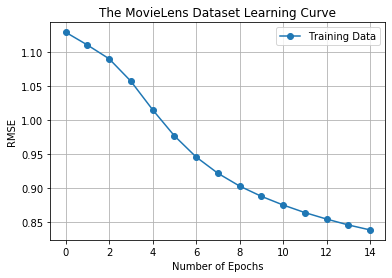

In [0]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Algorithm Peformance Comparison

In [0]:
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]

In [0]:
cv_rmse= CrossValidation('RMSE')
cv_patk= CrossValidation('P@K')
cv_ratk= CrossValidation('R@K')

In [0]:
cv_rmse_results= cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:10, 1968.71it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2037.04it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:10, 1995.07it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:10, 1979.48it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:10, 1994.69it/s]


Processing algorithm useraverage


20000it [00:09, 2022.75it/s]
20000it [00:09, 2033.31it/s]
20000it [00:10, 1972.02it/s]
20000it [00:10, 1981.66it/s]
20000it [00:09, 2031.02it/s]


Processing algorithm user-cosine


20000it [00:09, 2038.58it/s]
20000it [00:09, 2005.98it/s]
20000it [00:11, 1806.16it/s]
20000it [00:10, 1989.91it/s]
20000it [00:09, 2013.50it/s]


Processing algorithm item-cosine


20000it [00:10, 1996.12it/s]
20000it [00:09, 2059.02it/s]
20000it [00:10, 1980.03it/s]
20000it [00:10, 1976.96it/s]
20000it [00:10, 1996.07it/s]


Processing algorithm PMF


20000it [00:16, 1176.57it/s]
20000it [00:17, 1165.91it/s]
20000it [00:17, 1170.61it/s]
20000it [00:16, 1181.98it/s]
20000it [00:17, 1162.71it/s]


In [0]:
cv_patk_results= cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:10, 1980.90it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2029.64it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:10, 1929.91it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:10, 1974.22it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:10, 1989.91it/s]


Processing algorithm useraverage


20000it [00:09, 2008.63it/s]
20000it [00:09, 2035.94it/s]
20000it [00:09, 2022.42it/s]
20000it [00:09, 2008.43it/s]
20000it [00:09, 2074.01it/s]


Processing algorithm user-cosine


20000it [00:10, 1997.23it/s]
20000it [00:10, 1986.30it/s]
20000it [00:10, 1995.87it/s]
20000it [00:10, 1990.41it/s]
20000it [00:09, 2034.88it/s]


Processing algorithm item-cosine


20000it [00:09, 2002.35it/s]
20000it [00:10, 1934.28it/s]
20000it [00:10, 1996.15it/s]
20000it [00:10, 1956.26it/s]
20000it [00:09, 2047.34it/s]


Processing algorithm PMF


20000it [00:17, 1162.37it/s]
20000it [00:17, 1167.57it/s]
20000it [00:17, 1166.07it/s]
20000it [00:16, 1189.40it/s]
20000it [00:17, 1161.00it/s]


In [0]:
cv_ratk_results= cv_ratk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:10, 1984.21it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2003.51it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2034.99it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:10, 1999.38it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:10, 1998.74it/s]


Processing algorithm useraverage


20000it [00:09, 2052.26it/s]
20000it [00:10, 1959.69it/s]
20000it [00:09, 2019.66it/s]
20000it [00:09, 2049.65it/s]
20000it [00:09, 2039.37it/s]


Processing algorithm user-cosine


20000it [00:09, 2029.85it/s]
20000it [00:09, 2063.33it/s]
20000it [00:10, 1992.99it/s]
20000it [00:10, 1972.86it/s]
20000it [00:09, 2012.26it/s]


Processing algorithm item-cosine


20000it [00:09, 2020.05it/s]
20000it [00:09, 2033.52it/s]
20000it [00:10, 1989.36it/s]
20000it [00:10, 1997.80it/s]
20000it [00:09, 2002.82it/s]


Processing algorithm PMF


20000it [00:16, 1184.85it/s]
20000it [00:17, 1162.05it/s]
20000it [00:17, 1142.65it/s]
20000it [00:17, 1155.90it/s]
20000it [00:17, 1151.88it/s]


In [0]:
cv_rmse_results

{'PMF': [[0.987682897349766,
   0.9731241530500341,
   0.9628378098357965,
   0.9515745531116877,
   0.9668001022622114],
  0.9684039031218991,
  0.9518526923566646,
  0.9849551138871335],
 'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734]}

In [0]:
df_methods = pd.DataFrame(columns= ["RMSE CV mean", "RMSE CI", "P@K CV mean", "P@K CI","R@K CV mean",'R@K CI'], index=["PMF", "item-cosine", "user-cosine", "useraverage","popularity"])
for i in ["PMF", "item-cosine", "user-cosine", "useraverage","popularity"]:
  df_methods.loc[i, 'RMSE CV mean']= round(cv_rmse_results[i][1],3)
  df_methods.loc[i, 'RMSE CI']= [round(cv_rmse_results[i][2],3), round(cv_rmse_results[i][3],3)]
  df_methods.loc[i, 'P@K CV mean']= round(cv_patk_results[i][1],3)
  df_methods.loc[i, 'P@K CI']= [round(cv_patk_results[i][2],3), round(cv_patk_results[i][3],3)]
  df_methods.loc[i, 'R@K CV mean']= round(cv_ratk_results[i][1],3)
  df_methods.loc[i, 'R@K CI']= [round(cv_ratk_results[i][2],3), round(cv_ratk_results[i][3],3)]

In [0]:
df_methods

,RMSE CV mean,RMSE CI,P@K CV mean,P@K CI,R@K CV mean,R@K CI
PMF,0.968,"[0.952, 0.985]",0.544,"[0.404, 0.685]",0.478,"[0.36, 0.597]"
item-cosine,1.02,"[1.007, 1.033]",0.532,"[0.384, 0.681]",0.475,"[0.354, 0.596]"
user-cosine,1.017,"[1.009, 1.026]",0.556,"[0.41, 0.702]",0.486,"[0.369, 0.603]"
useraverage,1.044,"[1.029, 1.059]",0.474,"[0.342, 0.605]",0.441,"[0.329, 0.553]"
popularity,3.159,"[3.139, 3.179]",0.551,"[0.405, 0.696]",0.484,"[0.367, 0.601]"


**Note**: RMSE cannot be evaluated with the popularity baseline since it is just the most popular items relative to each other and not according to the actual ratings (it is between 0-1 whereas ratings are 0-5).

Results Summary:
- RMSE: PMF has the lowest RMSE value (0.97)
- P@K: User-cosine does the best (0.556)
- R@K: User-cosine does the best (0.486)

PMF is generally good overall since it optimizes the rating results and hence the error (RMSE) is low. However, simpler methods such as User-User CF perform very well when it comes to recall and precision. 

**Note**: RMSE directly compares the predicted rating to the actual rating. Perfect RMSE implies perfect ranking, but good RMSE is not required for good ranking. Unlike ranking, which focuses more on high-scoring items, RMSE places equal emphasis on high and low ratings.

Hence, recall and precision are important measures because users do not rate every thing they watch; recall and precision @k ensure that the first k recommendations made to the user is relevant. This could be given more importance in some Recommender Systems over RMSE.



## Making movie recommendations

In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
moviesDF.index[moviesDF['movieTitle']=="Men in Black (1997)"].tolist()

[256]

In [0]:
moviesDF.index[moviesDF['movieTitle']=="Schindler's List (1993)"].tolist()

[317]

In [0]:
moviesDF.index[moviesDF['movieTitle']=="Batman (1989)"].tolist()

[402]

In [0]:
train_matrix = dataPreprocessor(rating_df, num_users, num_items)
ii_similarity = SimBasedRecSys.cosine(train_matrix.T)

In [0]:
def itemTopK(prediction, moviesDataset, itemID, k):
    itemVector = prediction[itemID,:] 
    index = np.argsort(itemVector)[::-1][1:k+1]
    namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], index))
    return namesTopK

In [0]:
print('Movie Title: Men in Black (1997) \nRecommendations: \n')
itemTopK(ii_similarity, moviesDF, 256, 5)

Movie Title: Men in Black (1997) 
Recommendations: 



['Return of the Jedi (1983)',
 'Star Wars (1977)',
 'Independence Day (ID4) (1996)',
 'Toy Story (1995)',
 'Star Trek: First Contact (1996)']

In [0]:
print('Movie Title: Shawshank Redemption, The (1994)\nRecommendations: \n')
itemTopK(ii_similarity, moviesDF, 63, 5)

Movie Title: Shawshank Redemption, The (1994)
Recommendations: 



['Forrest Gump (1994)',
 'Raiders of the Lost Ark (1981)',
 'Silence of the Lambs, The (1991)',
 'Pulp Fiction (1994)',
 "Schindler's List (1993)"]

In [0]:
print('Movie Title: Batman (1989) \nRecommendations: \n')
itemTopK(ii_similarity, moviesDF, 402, 5)

Movie Title: Batman (1989) 
Recommendations: 



['Batman Returns (1992)',
 'Die Hard: With a Vengeance (1995)',
 'Jurassic Park (1993)',
 'Top Gun (1986)',
 'Die Hard 2 (1990)']

The recommendations do make sense since the recommended movies are similar to the original one in terms of the genres. For example, people who liked Batman would also probably like Batman Returns or other action movies such as Top Gun or Die Hard and hence it is showing up here.

People who liked Shawshank Redemption would also probably like Forrest Gump because of the drama and mystery genre.

## Testing with different user types

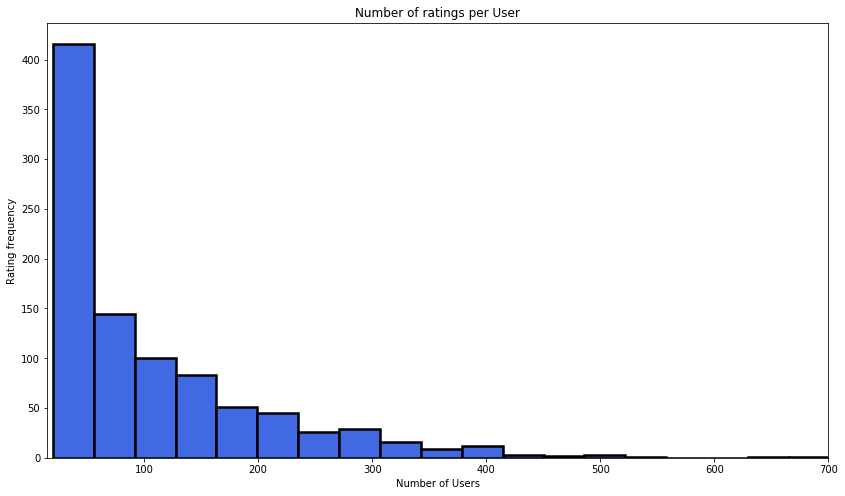

In [0]:
ratings_per_user= [np.size(userRatings.nonzero()) for userRatings in dataPreprocessor(rating_df, num_users, num_items)]

# Plot histogram
plt.figure(figsize=(14,8))
plt.hist(ratings_per_user, bins=20,color="royalblue",edgecolor = "black",linewidth = 2.5)
plt.title("Number of ratings per User")
plt.ylabel('Rating Frequency')
plt.xlim((15,700))
plt.xlabel('Number of Users')
plt.show()

It is evident that there are very few users that have rated a large number of items whereas there are so many users that have rated less than 100 items.

τ is chosen as 70 to ensure there is a similar number of users both above and below threshold to aid comparison.

In [0]:
def threshold_CF(train_matrix, type):
        
  if type == 'user':

      temp_matrix = np.zeros(train_matrix.shape)
      temp_matrix[train_matrix.nonzero()] = 1 

      uu_similarity= 1 - pairwise_distances(train_matrix, metric='cosine')

      normalizer = np.matmul(uu_similarity, temp_matrix)
      #print(normalizer)
      normalizer[normalizer == 0] = 1e-5
      predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
      # if no one has rated this item before, use user average  
      useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
      columns = np.sum(predictionMatrix, axis=0)
    
      predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
      
      return predictionMatrix
            
  elif type == 'item':

        train_matrix= train_matrix.T
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1

        ii_similarity= 1 - pairwise_distances(train_matrix, metric='cosine')

        normalizer = np.matmul(ii_similarity, temp_matrix)
        normalizer[normalizer == 0] = 1e-5
            
        predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
        #predictionMatrix[temp_matrix.nonzero()] = 0
        #Cold start
        # if no one has rated this item before, use user average  
        itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
        columns = np.sum(predictionMatrix, axis=0)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)

        return predictionMatrix.T

In [0]:
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    pred_data = pred[test.nonzero()].flatten() 
    test_data = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(pred_data, test_data))

In [0]:
temp_matrix = np.zeros(train_matrix.shape)
temp_matrix[train_matrix.nonzero()] = 1
ratings_per_user_matrix = np.sum(temp_matrix, axis=1)

#### Above threshold τ of liked items

In [0]:
threshold= 70

In [0]:
user_above_threshold = train_matrix[ratings_per_user_matrix >= threshold]

In [0]:
user_above_threshold_prediction = threshold_CF(user_above_threshold, 'user')
item_above_threshold_prediction = threshold_CF(user_above_threshold, 'item')

In [0]:
rmse_user_above_threshold = rmse(user_above_threshold_prediction, user_above_threshold)
rmse_item_above_threshold = rmse(item_above_threshold_prediction, user_above_threshold)
print("User-User CF above threshold RMSE= ", rmse_user_above_threshold)
print("Item-Item CF above threshold RMSE= ", rmse_item_above_threshold)

User-User CF above threshold RMSE=  0.9482696568348582
Item-Item CF above threshold RMSE=  0.9897516097708328


#### Below threshold τ of liked items

In [0]:
user_below_threshold = train_matrix[ratings_per_user_matrix < threshold]

In [0]:
user_below_threshold_prediction = threshold_CF(user_below_threshold, 'user')
item_below_threshold_prediction = threshold_CF(user_below_threshold, 'item')

In [0]:
rmse_user_below_threshold = rmse(user_below_threshold_prediction, user_below_threshold)
rmse_item_below_threshold = rmse(item_below_threshold_prediction, user_below_threshold)
print("User-User CF below threshold RMSE= ", rmse_user_below_threshold)
print("Item-Item CF below threshold RMSE= ", rmse_item_below_threshold)

User-User CF below threshold RMSE=  0.8786089115422199
Item-Item CF below threshold RMSE=  0.8819031886314748


The users below the threshold have rated lower movies and hence it is easier to compute similarties between them and the items and make predictions.
Users above the threshold have rated a lot of movies and hence it makes it difficult to predict what type of movies they would like in particular.